In [1]:
%run external_field_modification.py

# Warp
# Origin date: Tue, 7 Jan 2020 09:31:24 -0700
# Local date: Tue, 7 Jan 2020 09:31:24 -0700
# Commit hash: 4ebb54f
# /home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/warp/warp.py
# /home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/warp/warpC.cpython-37m-x86_64-linux-gnu.so
# Tue May  5 22:49:48 2020
# import warp time 0.10396623611450195 seconds
# For more help, type warphelp()
 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments


In [2]:
import matplotlib.pyplot as plt

# Setting and dynamically changing background fields

This example discusses setting and editing background E and B fields in Warp. These fields are applied directly to the PIC mesh and are defined external to the solver. THey are not known to Warp's `FieldSolver`, which only considers particles and boundary conditions when defining the field, and will not be evident if fields are queried through a `FieldSolver`. 

The setup external E and B fields is couched as a means to setup elements that would appear in accelerator particle tracking simulations. Traditionally this would mean that these fields may not be positioned in the solver domain at every time step and that they are not necessarily meant to be dynamically edited, with some exceptions.

Here we walk through setting up an externall and (nominally) static electric field and then show how it may be updated between solver steps. It should be noted that if the time-varying behavior of a field is known a priori there are options to supply this during setup of the external field, so that direct editing of the array containing the field data will not be required.

## Adding a background electric field

This is most easily accomplished with the `addnewegrd` function which will take care of setting a number of parameters in `top` that are required to define and place the electric field grid data. 
The initial setup for this is taken care of in `external_field_modification.py` under  **Install Background Field(s)**

<code>
ez = np.zeros([wp.w3d.nx, wp.w3d.ny, wp.w3d.nz])
ez[:, :, :] = 1e5  # V/m
z_start = wp.w3d.zmmin 
z_stop = wp.w3d.zmmax 
dx = (wp.w3d.xmmax - wp.w3d.xmmin) / wp.w3d.nx 

wp.addnewegrd(z_start, z_stop, 
              xs=wp.w3d.xmmin / 2., dx=dx/2., 
              ys=wp.w3d.ymmin, dy=(wp.w3d.ymmax - wp.w3d.ymmin), 
              nx=wp.w3d.nx, ny=wp.w3d.ny, nz=wp.w3d.nz, ez=ez) 
</code>

This defines a uniform field of 0.1 MV. The block extends the full width of the domain in y and z. It covers the middle half of the domain in x. 
A couple of notes:
- The external field does not have to be defined matching to the solver mesh. We have only done that here for convenience in positioning.
- While we are using a 2D solver (XZ plane) you may see weird behavior (zero field most likely) if you do not define the field in some finite region in y as well.



## External field quantities

All data for external fields is stored in `top` the list of variable names can be found in **top.v** under `EGRDdata dump`.  

In [3]:
# x position where the grid starts
wp.top.egrdxs

array([-0.025])

In [4]:
# extent of the grid in x based on the number of cells in the grid and their separation
wp.top.egrdnx * wp.top.egrddx

array([0.0475])

In [5]:
# part of the Ez array (truncated for formatting)
wp.top.egrdez[:5, :5, :5, 0]

array([[[100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.]],

       [[100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.]],

       [[100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.]],

       [[100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
        [100000., 100000., 100000., 100000., 100000.],
    

## Demonstration and update sequence 

Make a copy of initial particle positions to compare to later on

In [6]:
xo = beam.getx().copy()
zo = beam.getz().copy()

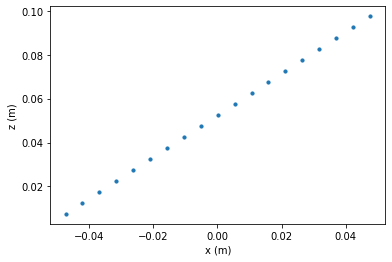

In [7]:
plt.figure()
plt.scatter(xo,
            zo, s=10)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.show()

### Take one step so we can impact of field

In [8]:
wp.step(1)

 ***  particle simulation package W3D running


We can see that only particles in the central half of the domain - where the field is defined - have moved

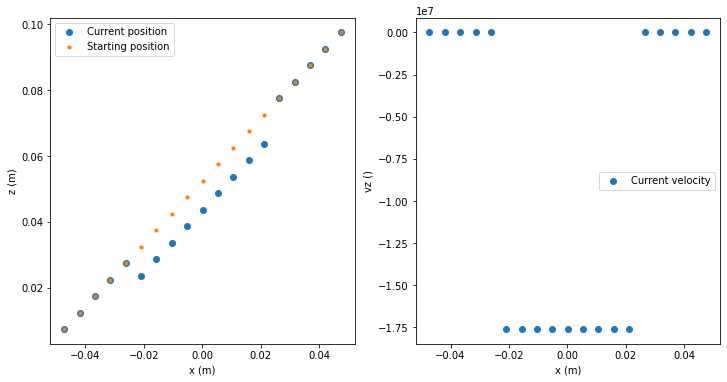

In [9]:
fig1, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(beam.getx(),
            beam.getz(), label='Current position')
ax1.scatter(xo,
            zo, s=10, label='Starting position')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('z (m)')
ax1.legend()

ax2.scatter(beam.getx(),
            beam.getvz(), label='Current velocity')

ax2.set_xlabel('x (m)')
ax2.set_ylabel('vz ()')
ax2.legend()

plt.show()

### Update the field
If we just want to modify the field in the same region this can be done by modifying the values in the existing array

In [10]:
wp.top.egrdez = wp.top.egrdez * -1

In [11]:
wp.top.egrdez[:5, :5, :5, 0]

array([[[-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.]],

       [[-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.]],

       [[-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -100000., -100000., -100000.]],

       [[-100000., -100000., -100000., -100000., -100000.],
        [-100000., -100000., -1000

The only catch is that you must call `gchange` specifiying the `EGRDdata` group for the change to be registered

In [12]:
wp.gchange('EGRDdata')

Now take several steps to see the impact of the change

In [13]:
wp.step(3)

The particles have no reversed direction because of the update to the field

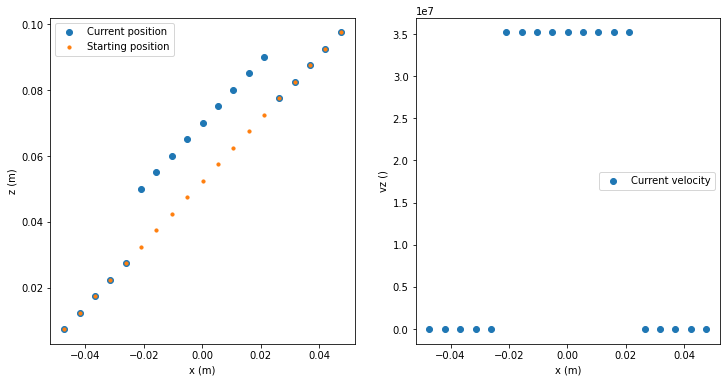

In [14]:
fig1, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(beam.getx(),
            beam.getz(), label='Current position')
ax1.scatter(xo,
            zo, s=10, label='Starting position')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('z (m)')
ax1.legend()

ax2.scatter(beam.getx(),
            beam.getvz(), label='Current velocity')

ax2.set_xlabel('x (m)')
ax2.set_ylabel('vz ()')
ax2.legend()

plt.show()